# Supervised ML: k-NN model

In [15]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import *
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from itertools import product
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading the dataset

In [2]:

data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

print(data.head())
print(data.info())
print(data.describe())

   Carbon_concentration  Silicon_concentration  Manganese_concentration  \
0                 0.037                   0.30                     0.65   
1                 0.037                   0.30                     0.65   
2                 0.037                   0.30                     0.65   
3                 0.037                   0.31                     1.03   
4                 0.037                   0.31                     1.03   

  Sulphur_concentration Phosphorus_concentration Nickel_concentration  \
0                 0.008                    0.012                    0   
1                 0.008                    0.012                    0   
2                 0.008                    0.012                    0   
3                 0.007                    0.014                    0   
4                 0.007                    0.014                    0   

  Chromium_concentration Molybdenum_concentration Vanadium_concentration  \
0                      N          

## Finding best hyperparameters with grid Search 

In [42]:
class ModelSelector:
    
    def __init__(self, *, model_class, labels_selected: list, data, param_grid_data, param_grid_model, kfold_splits):
        self.model_class = model_class
        self.labels_selected = labels_selected
        self.data = data
        self.param_grid_data = param_grid_data
        self.param_grid_model = param_grid_model
        self.kfold_splits = kfold_splits
        
    def extract_x_y(self):
        # Replace 'N' values with NaN
        data = replace_data(self.data)

        # Select the data for supervised learning (only rows where labels are not missing)
        data_copy = data.copy()
        data_with_label = data_copy[data_copy[self.labels_selected].notna().all(axis=1)]

        # Separate features and labels
        self.X, self.y = choose_labels(data_with_label, labels_chosen=self.labels_selected)
            
    def split(self, test_size=0.2, random_state=12):
        # Split data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=True, random_state=random_state)
        
    def apply_pipeline(self, X_train, X_test, y_train, y_test, params):
        # Apply the preprocessing pipeline with the provided parameters
        return pipeline_training_set(
            training_set=X_train, training_labels=y_train,
            testing_set=X_test, testing_labels=y_test, 
            labels_chosen=self.labels_selected,
            categorical_strategy=params['CategoricalStrategies'], 
            ordinal_strategy=params['OrdinalStrategies'], 
            is_PCA=params['is_PCA'], 
            pca_percent_explained_variance=params['pca_percent_explained_variance'],
            scaler_strategy=params['ScalerStrategy'], 
            pca_columns=params['PcaColumns'], 
            less_than_strategy=params['LessThanStrategy']
        )
        
    def cross_validation(self):
        # K-Fold cross-validation
        kfolds = KFold(n_splits=self.kfold_splits, shuffle=True, random_state=12)
        
        # Dictionary to store the average RMSE for each combination of hyperparameters
        results = {}

        # Generate all combinations of hyperparameters
        param_grid_total = self.param_grid_data | self.param_grid_model
        keys, values = zip(*param_grid_total.items())
        combinations = list(product(*values))

        # Iterate through each combination of hyperparameters
        for combo in combinations:
            params = dict(zip(keys, combo))
            
            rmse_list = []  # To store RMSE for each fold

            for fold, (train_index, val_index) in enumerate(kfolds.split(self.X_train, self.y_train)):
                model = self.model_class(**{k: v for k, v in params.items() if k in self.param_grid_model})
                
                X_sub_train = self.X_train.iloc[train_index, :]
                X_sub_val = self.X_train.iloc[val_index, :]
                y_sub_train = self.y_train.iloc[train_index]
                y_sub_val = self.y_train.iloc[val_index]

                # Apply the pipeline with the current parameters
                X_sub_train, X_sub_val, y_sub_train, y_sub_val = self.apply_pipeline(X_sub_train, X_sub_val, y_sub_train, y_sub_val, params)
                
                # Train and predict
                model.fit(X_sub_train, y_sub_train.to_numpy().ravel())
                y_sub_pred = model.predict(X_sub_val)
                
                # Calculate RMSE
                mse = mean_squared_error(y_sub_pred, y_sub_val)
                rmse = np.sqrt(mse)
                rmse_list.append(rmse)

            # Compute the average RMSE for this combination
            mean_rmse = np.mean(rmse_list)
            results[tuple(combo)] = mean_rmse

        # Find the best hyperparameter combination
        best_combo = min(results, key=results.get)
        self.best_rmse = results[best_combo]
        self.best_params = dict(zip(keys, best_combo))

        print("Best hyperparameters with cross-validation: {}".format(self.best_params))
        print("Best Mean RMSE on cross-validation: {:.3}".format(self.best_rmse))
    
    def score(self):
        # Apply the pipeline with the best hyperparameters
        X_train, X_test, y_train, y_test = self.apply_pipeline(self.X_train, self.X_test, self.y_train, self.y_test, self.best_params)
        
        # Train the model with the best parameters
        model = self.model_class(**{k: v for k, v in self.best_params.items() if k in self.param_grid_model})
        model.fit(X_train, y_train.to_numpy().ravel())
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        # Calculate training and test RMSE
        train_mse = mean_squared_error(y_train_pred, y_train)
        train_rmse = np.sqrt(train_mse)
        test_mse = mean_squared_error(y_pred, y_test)
        self.test_rmse = np.sqrt(test_mse)
        
        # Calculate R-squared score
        r2 = r2_score(y_test, y_pred)
        
        # Output results
        print("Final RMSE on train set: {:.3}".format(train_rmse))
        print("Final RMSE on test set: {:.3}".format(self.test_rmse))
        print("Final R2 on test set: {:.3}".format(r2))
        
        return y_pred, y_test
        
    def plot(self, y_pred, y_test):
        # Plot predicted vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, y_test, color='blue', label='Predicted vs Actual')
        plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2, label='Ideal Fit')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Actual vs Predicted')
        plt.legend()
        plt.show()

In [ ]:
model_class = KNeighborsRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {'OrdinalStrategies': ['mean', 'linear'], 'CategoricalStrategies': ['logistic','most_frequent' ], 'ScalerStrategy': ['standard'],
                   'pca_percent_explained_variance': [0.5, 0.6, 0.7, 0.8, 0.85, 0.9], 'PcaColumns': ['all_ordinals', 'concentrations'], 'LessThanStrategy': ['mean'], 'is_PCA': [False]}

param_grid_KNN = {
    'n_neighbors': [1,3,5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'leaf_size': [ 20, 30, 40, 50, 55, 60, 65, 70],
    'p': [1, 2, 3]
}

kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_KNN, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()

#Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'logistic', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.85, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'is_PCA': False, 'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 55, 'p': 1}
# Best Mean RMSE on cross-validation: 55.3
# Final RMSE on train set: 2.22
# Final RMSE on test set: 48.2
# Final R2 on test set: 0.75


## Best hyperparameters for neural network

- is_PCA = False

- Ordinal Strategy: mean

- Categorical Strategy: logistic

- Scaler: standardization

- k (number of neighbors): 3

- weights (k-NN model): distance

- leaf size: 55

- p: 1 (Manhattan distance)

## Results

- Best Mean RMSE on cross-validation: 57.0
- Final RMSE on train set: 2.34
- Final RMSE on test set: 45.1
- Final R2 on test set: 0.781

## Influence of the number of neighbors k on performance

Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'logistic', 'ScalerStrategy': 'standard', 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'pca_percent_explained_variance': 0.85, 'is_PCA': False, 'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 55, 'p': 1}
Best Mean RMSE on cross-validation: 64.8
Final RMSE on train set: 3.8
Final RMSE on test set: 61.1
Final R2 on test set: 0.598
Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'logistic', 'ScalerStrategy': 'standard', 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'pca_percent_explained_variance': 0.85, 'is_PCA': False, 'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 55, 'p': 1}
Best Mean RMSE on cross-validation: 57.3
Final RMSE on train set: 2.5
Final RMSE on test set: 47.4
Final R2 on test set: 0.759
Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'lo

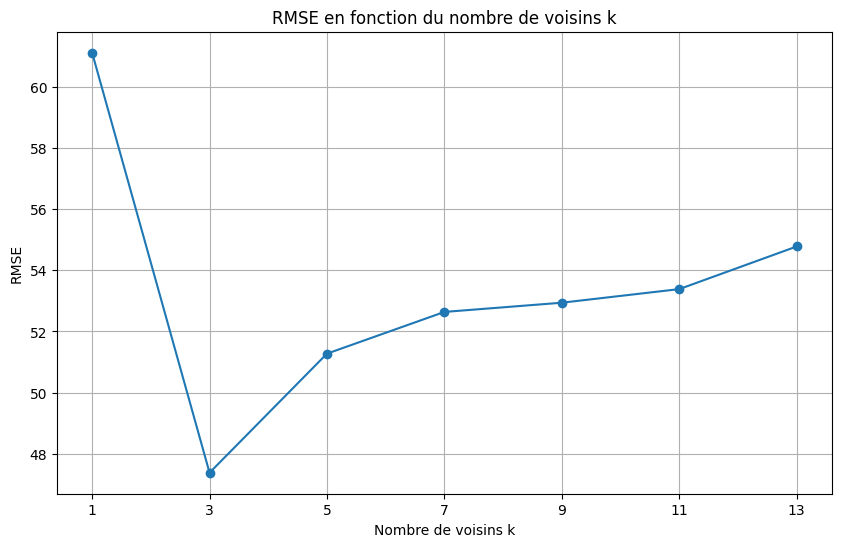

In [47]:
fixed_params = {
    'OrdinalStrategies': 'mean',
    'CategoricalStrategies': 'logistic',
    'ScalerStrategy': 'standard',
    'pca_percent_explained_variance': 0.85,
    'PcaColumns': 'all_ordinals',
    'LessThanStrategy': 'mean',
    'weights': 'distance',
    'leaf_size': 55,
    'p': 1,
    'n_neighbors': 3
}

# Liste des valeurs de n_neighbors à tester
n_neighbors_list = [1, 3, 5, 7, 9, 11, 13]
rmse_list = []

for k in n_neighbors_list:
    # Mise à jour du paramètre n_neighbors
    params = fixed_params.copy()
    params['n_neighbors'] = k

    # Création du grid des hyperparamètres
    param_grid_data = {
        'OrdinalStrategies': [params['OrdinalStrategies']],
        'CategoricalStrategies': [params['CategoricalStrategies']],
        'ScalerStrategy': [params['ScalerStrategy']],
        'PcaColumns': [params['PcaColumns']],
        'LessThanStrategy': [params['LessThanStrategy']],
        'pca_percent_explained_variance': [params['pca_percent_explained_variance']],
        'is_PCA': [False]
    }

    param_grid_model = {
        'n_neighbors': [params['n_neighbors']],
        'weights': [params['weights']],
        'leaf_size': [params['leaf_size']],
        'p': [params['p']]
    }

    # Création de l'instance du sélecteur de modèle
    selector = ModelSelector(
        model_class=KNeighborsRegressor,
        labels_selected = ["Yield_strength"], 
        data=data,  
        param_grid_data=param_grid_data,
        param_grid_model=param_grid_model,
        kfold_splits=5
    )

    # Préparation des données
    selector.extract_x_y()
    selector.split()

    # Exécution de la validation croisée
    selector.cross_validation()
    selector.score()

    # Enregistrement du score RMSE
    rmse_list.append(selector.test_rmse)

# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_list, rmse_list, marker='o')
plt.title('RMSE en fonction du nombre de voisins k')
plt.xlabel('Nombre de voisins k')
plt.ylabel('RMSE')
plt.xticks(n_neighbors_list)
plt.grid(True)
plt.show()

Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'logistic', 'ScalerStrategy': 'standard', 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'pca_percent_explained_variance': 0.85, 'is_PCA': False, 'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 55, 'p': 1}
Best Mean RMSE on cross-validation: 57.0
Final RMSE on train set: 2.34
Final RMSE on test set: 45.1
Final R2 on test set: 0.781


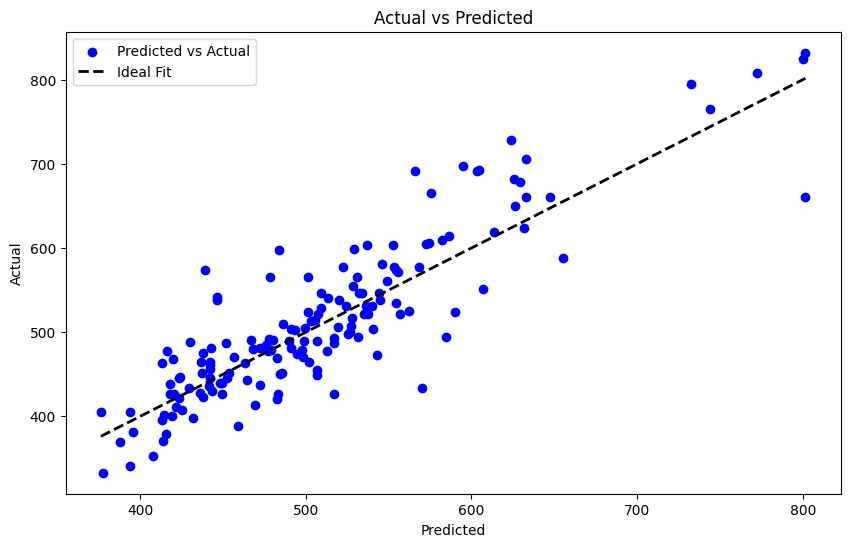

In [32]:
fixed_params = {
    'OrdinalStrategies': 'mean',
    'CategoricalStrategies': 'logistic',
    'ScalerStrategy': 'standard',
    'pca_percent_explained_variance': 0.85,
    'PcaColumns': 'all_ordinals',
    'LessThanStrategy': 'mean',
    'weights': 'distance',
    'leaf_size': 55,
    'p': 1,
    'n_neighbors': 3
}

param_grid_data = {
    'OrdinalStrategies': [fixed_params['OrdinalStrategies']],
    'CategoricalStrategies': [fixed_params['CategoricalStrategies']],
    'ScalerStrategy': [fixed_params['ScalerStrategy']],
    'PcaColumns': [fixed_params['PcaColumns']],
    'LessThanStrategy': [fixed_params['LessThanStrategy']],
    'pca_percent_explained_variance': [fixed_params['pca_percent_explained_variance']],
    'is_PCA': [False]
}

param_grid_model = {
    'n_neighbors': [fixed_params['n_neighbors']],
    'weights': [fixed_params['weights']],
    'leaf_size': [fixed_params['leaf_size']],
    'p': [fixed_params['p']]
}

model = ModelSelector(
        model_class=KNeighborsRegressor,
        labels_selected = ["Yield_strength"], 
        data=data,  
        param_grid_data=param_grid_data,
        param_grid_model=param_grid_model,
        kfold_splits=5
    )

model.extract_x_y()
model.split()
model.cross_validation()
y_pred, y_test = model.score()
model.plot(y_pred, y_test)

